# Análisis Exploratorio de Datos - Clasificador de Movimientos Corporales

Este notebook contiene un análisis exploratorio completo de los datos extraídos de videos de movimientos corporales usando MediaPipe. El objetivo es desarrollar un clasificador que pueda identificar 5 tipos de movimientos: *caminar hacia la cámara*, *caminar de regreso*, *girar*, *sentarse*, *ponerse de pie*.

## Integrantes
- Juan David Colonia Aldana - **A00395956**
- Miguel Angel Gonzalez Arango - **A00395687**
- Pablo Fernando Pineda Patiño - **A00395831**

## Estructura de los Datos
- **Fuente**: Videos procesados con MediaPipe para extraer landmarks de poses
- **Formato**: frame, movement, nose_x, nose_y, nose_z, nose_v, left_shoulder_x, ...
- **Target**: movement (5 clases: turning, sit_down, stand_up, walk_forward, walk_backward)
- **Features**: Coordenadas 3D (x, y, z) y visibilidad (v) de 11 landmarks corporales

## Contenido del Análisis

1. **Carga y Exploración Inicial de Datos**
2. **Análisis de Calidad de Datos**
3. **Análisis de Distribución de Clases**
4. **Análisis de Landmarks y Visibilidad**
5. **Análisis de Distribuciones de Coordenadas**
6. **Análisis Temporal de Secuencias**
7. **Tratamiento de Datos Nulos y Duplicados**
8. **Tratamiento de Outliers**
9. **Análisis de Separabilidad de Clases (PCA)**
10. **Validación Final de Calidad**
11. **Exportación**

In [40]:
# Importaciones necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Librerías importadas exitosamente")

Librerías importadas exitosamente


## 1. Carga y Exploración Inicial de Datos

In [41]:
# Cargar los datos
df = pd.read_csv('../data/processed/combined_dataset.csv')

print("Dataset cargado exitosamente!")
print(f"Dimensiones del dataset: {df.shape}")
print(f"Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset cargado exitosamente!
Dimensiones del dataset: (13672, 54)
Memoria utilizada: 6.30 MB


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13672 entries, 0 to 13671
Data columns (total 54 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   frame             13672 non-null  int64  
 1   movement          13672 non-null  object 
 2   nose_x            13614 non-null  float64
 3   nose_y            13614 non-null  float64
 4   nose_z            13614 non-null  float64
 5   nose_v            13614 non-null  float64
 6   left_shoulder_x   13614 non-null  float64
 7   left_shoulder_y   13614 non-null  float64
 8   left_shoulder_z   13614 non-null  float64
 9   left_shoulder_v   13614 non-null  float64
 10  right_shoulder_x  13614 non-null  float64
 11  right_shoulder_y  13614 non-null  float64
 12  right_shoulder_z  13614 non-null  float64
 13  right_shoulder_v  13614 non-null  float64
 14  left_wrist_x      13614 non-null  float64
 15  left_wrist_y      13614 non-null  float64
 16  left_wrist_z      13614 non-null  float6

In [43]:
display(df.head(10))

,frame,movement,nose_x,nose_y,nose_z,nose_v,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_v,right_shoulder_x,right_shoulder_y,right_shoulder_z,right_shoulder_v,left_wrist_x,left_wrist_y,left_wrist_z,left_wrist_v,right_wrist_x,right_wrist_y,right_wrist_z,right_wrist_v,left_hip_x,left_hip_y,left_hip_z,left_hip_v,right_hip_x,right_hip_y,right_hip_z,right_hip_v,left_knee_x,left_knee_y,left_knee_z,left_knee_v,right_knee_x,right_knee_y,right_knee_z,right_knee_v,left_ankle_x,left_ankle_y,left_ankle_z,left_ankle_v,right_ankle_x,right_ankle_y,right_ankle_z,right_ankle_v,left_heel_x,left_heel_y,left_heel_z,left_heel_v,right_heel_x,right_heel_y,right_heel_z,right_heel_v
0,0,turning,0.5782,0.1848,-0.4297,0.9999,0.6185,0.3015,-0.2138,0.9999,0.5300,0.2897,-0.1833,0.9999,0.6271,0.5313,-0.1964,0.9394,0.4969,0.5134,-0.0998,0.8478,0.5942,0.5149,0.0023,0.9997,0.5405,0.5150,-0.0023,0.9998,0.5959,0.6811,0.0295,0.9629,0.5421,0.6779,-0.0051,0.9928,0.5957,0.8300,0.2170,0.9787,0.5453,0.8287,0.1700,0.9915,0.5897,0.8497,0.2276,0.9006,0.5481,0.8505,0.1790,0.8507
1,1,turning,0.5771,0.1827,-0.4346,0.9999,0.6169,0.3005,-0.2198,0.9999,0.5280,0.2896,-0.1938,0.9999,0.6317,0.5308,-0.2062,0.9427,0.4978,0.5136,-0.1382,0.8440,0.5943,0.5146,-0.0007,0.9997,0.5413,0.5149,0.0007,0.9997,0.5933,0.6837,0.0289,0.9656,0.5423,0.6816,0.0075,0.9927,0.5942,0.8332,0.2132,0.9798,0.5454,0.8320,0.1791,0.9912,0.5882,0.8528,0.2234,0.8940,0.5506,0.8541,0.1880,0.8498
2,2,turning,0.5760,0.1818,-0.4329,0.9999,0.6160,0.2997,-0.2155,0.9999,0.5271,0.2892,-0.1932,0.9999,0.6322,0.5310,-0.2033,0.9443,0.5004,0.5140,-0.1348,0.8293,0.5935,0.5140,-0.0015,0.9997,0.5412,0.5149,0.0015,0.9997,0.5924,0.6843,0.0212,0.9680,0.5422,0.6834,-0.0013,0.9923,0.5938,0.8349,0.2132,0.9808,0.5455,0.8342,0.1743,0.9910,0.5877,0.8538,0.2244,0.8880,0.5517,0.8551,0.1837,0.8486
3,3,turning,0.5747,0.1818,-0.4303,0.9999,0.6147,0.2993,-0.2138,0.9999,0.5261,0.2891,-0.1902,0.9999,0.6325,0.5309,-0.1974,0.9473,0.5026,0.5138,-0.1329,0.8186,0.5925,0.5141,-0.0006,0.9997,0.5406,0.5153,0.0005,0.9997,0.5924,0.6856,0.0249,0.9703,0.5418,0.6838,-0.0047,0.9922,0.5941,0.8360,0.2200,0.9819,0.5456,0.8355,0.1750,0.9912,0.5877,0.8549,0.2313,0.8862,0.5517,0.8556,0.1846,0.8499
4,4,turning,0.5736,0.1816,-0.4323,0.9999,0.6142,0.2991,-0.2115,0.9999,0.5262,0.2877,-0.1903,0.9999,0.6326,0.5309,-0.2042,0.9498,0.5035,0.5121,-0.1472,0.8100,0.5917,0.5140,0.0002,0.9997,0.5403,0.5153,-0.0002,0.9997,0.5913,0.6862,0.0218,0.9723,0.5414,0.6839,-0.0108,0.9921,0.5945,0.8364,0.2213,0.9828,0.5456,0.8369,0.1709,0.9911,0.5880,0.8553,0.2329,0.8827,0.5516,0.8562,0.1807,0.8487
5,5,turning,0.5725,0.1816,-0.4325,0.9999,0.6134,0.2991,-0.2121,0.9999,0.5258,0.2875,-0.1886,0.9999,0.6324,0.5309,-0.2163,0.9526,0.5031,0.5072,-0.1496,0.8133,0.5910,0.5143,-0.0007,0.9997,0.5401,0.5153,0.0007,0.9997,0.5911,0.6874,0.0215,0.9740,0.5411,0.6843,-0.0099,0.9920,0.5947,0.8372,0.2232,0.9833,0.5456,0.8381,0.1716,0.9910,0.5881,0.8556,0.2349,0.8772,0.5516,0.8572,0.1813,0.8478
6,6,turning,0.5714,0.1816,-0.4346,0.9999,0.6127,0.2992,-0.2144,0.9999,0.5250,0.2873,-0.1894,0.9999,0.6315,0.5310,-0.2223,0.9551,0.5002,0.5076,-0.1505,0.8221,0.5901,0.5143,-0.0004,0.9997,0.5389,0.5151,0.0003,0.9997,0.5911,0.6875,0.0204,0.9755,0.5406,0.6842,-0.0088,0.9919,0.5947,0.8378,0.2170,0.9839,0.5456,0.8386,0.1678,0.9908,0.5881,0.8562,0.2283,0.8729,0.5515,0.8579,0.1770,0.8470
7,7,turning,0.5708,0.1817,-0.4503,0.9999,0.6124,0.2996,-0.2224,0.9999,0.5237,0.2878,-0.2117,0.9999,0.6300,0.5312,-0.2115,0.9561,0.4989,0.5152,-0.1760,0.8312,0.5894,0.5143,-0.0002,0.9997,0.5375,0.5151,0.0002,0.9997,0.5912,0.6877,0.0206,0.9770,0.5402,0.6841,-0.0071,0.9920,0.5945,0.8378,0.2127,0.9845,0.5454,0.8386,0.1701,0.9908,0.5877,0.8566,0.2239,0.8731,0.5513,0.8578,0.1797,0.8461
8,8,turning,0.5702,0.1817,-0.4517,1.0000,0.6119,0.2995,-0.2245,0.9999,0.5232,0.2878,-0.2109,0.9999,0.6286,0.5322,-0.2126,0.9580,0.4983,0.5160,-0.1900,0.8416,0.5890,0.5142,0.0004,0.9997,0.5366,0.5150,-0.0004,0.9997,0.5911,0.6877,0.0227,0.9783,0.5402,0.68

In [44]:
display(df.describe())

,frame,nose_x,nose_y,nose_z,nose_v,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_v,right_shoulder_x,right_shoulder_y,right_shoulder_z,right_shoulder_v,left_wrist_x,left_wrist_y,left_wrist_z,left_wrist_v,right_wrist_x,right_wrist_y,right_wrist_z,right_wrist_v,left_hip_x,left_hip_y,left_hip_z,left_hip_v,right_hip_x,right_hip_y,right_hip_z,right_hip_v,left_knee_x,left_knee_y,left_knee_z,left_knee_v,right_knee_x,right_knee_y,right_knee_z,right_knee_v,left_ankle_x,left_ankle_y,left_ankle_z,left_ankle_v,right_ankle_x,right_ankle_y,right_ankle_z,right_ankle_v,left_heel_x,left_heel_y,left_heel_z,left_heel_v,right_heel_x,right_heel_y,right_heel_z,right_heel_v
count,13672.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000,13614.0000
mean,52.7488,0.5461,0.2716,-0.1539,0.9995,0.5674,0.3539,-0.0802,0.9998,0.5276,0.3541,-0.0716,0.9997,0.5705,0.5534,-0.0963,0.8621,0.5231,0.5509,-0.0861,0.8423,0.5585,0.5537,-0.0018,0.9935,0.5340,0.5530,0.0017,0.9935,0.5622,0.6910,-0.0563,0.9595,0.5314,0.6907,-0.0373,0.9579,0.5602,0.8399,0.0577,0.9503,0.5329,0.8400,0.0723,0.9479,0.5565,0.8604,0.0643,0.8790,0.5351,0.8601,0.0787,0.8646
std,34.9012,0.0399,0.0917,0.2560,0.0021,0.0541,0.0792,0.1140,0.0015,0.0669,0.0782,0.1231,0.0018,0.0688,0.0909,0.1442,0.1724,0.0817,0.0905,0.1567,0.1774,0.0409,0.0912,0.0300,0.0699,0.0516,0.0916,0.0300,0.0699,0.0436,0.1228,0.1535,0.1049,0.0543,0.1239,0.1517,0.1019,0.0426,0.1686,0.1685,0.1259,0.0524,0.1688,0.1652,0.1309,0.0421,0.1768,0.1726,0.1500,0.0498,0.1766,0.1692,0.1590
min,0.0000,0.3168,-0.2709,-1.2767,0.9339,0.2683,-0.1368,-0.8954,0.9292,0.2013,-0.1131,-0.9045,0.9135,0.1252,0.2736,-1.3525,0.0276,0.0867,0.2965,-1.2515,0.0481,0.3383,-0.0479,-0.1647,0.0027,0.2831,-0.0381,-0.1602,0.0030,0.3455,0.3074,-0.7700,0.0011,0.3007,0.2223,-0.7077,0.0004,0.3587,0.3807,-0.6626,0.0001,0.3615,0.3772,-0.8304,0.0001,0.3523,0.3741,-0.7372,0.0001,0.3759,0.3805,-0.8768,0.0001
25%,24.0000,0.5273,0.1968,-0.3311,0.9998,0.5311,0.2955,-0.1431,0.9999,0.4913,0.2937,-0.1372,0.9998,0.5263,0.5077,-0.1959,0.8194,0.4749,0.5051,-0.1838,0.8166,0.5311,0.5107,-0.0082,0.9995,0.5097,0.5101,-0.0034,0.9995,0.5272,0.6382,-0.0778,0.9759,0.4984,0.6420,-0.0641,0.9710,0.5255,0.7457,-0.0189,0.9688,0.4985,0.7639,0.0152,0.9660,0.5240,0.7617,-0.0194,0.8451,0.5023,0.7769,0.0148,0.8339
50%,48.0000,0.5419,0.2667,-0.2213,1.0000,0.5821,0.3473,-0.0777,0.9999,0.5225,0.3470,-0.0715,0.9999,0.5866,0.5326,-0.1154,0.9357,0.5100,0.5310,-0.1045,0.9083,0.5669,0.5280,-0.0008,0.9998,0.5338,0.5259,0.0009,0.9997,0.5777,0.6952,-0.0108,0.9895,0.5337,0.6944,0.0003,0.9864,0.5736,0.8489,0.0864,0.9843,0.5347,0.8532,0.1036,0.9819,0.5679,0.8734,0.0912,0.9126,0.5345,0.8771,0.1079,0.9045
75%,77.0000,0.5656,0.3347,0.0998,1.0000,0.5993,0.3931,-0.0215,1.0000,0.5731,0.3941,-0.0110,1.0000,0.6115,0.5758,0.0090,0.9748,0.5798,0.5733,0.0162,0.9546,0.5834,0.5722,0.0033,0.9999,0.5626,0.5725,0.0081,0.9998,0.5893,0.7246,0.0316,0.9939,0.5651,0.7248,0.0566,0.9927,0.5864,0.9036,0.1653,0.9908,0.5648,0.9024,0.1716,0.9897,0.5799,0.9254,0.1747,0.9682,0.5634,0.9238,0.1801,0.9601
max,149.0000,0.6744,0.8213,1.5684,1.0000,0.8981,1.0751,1.1429,1.0000,0.8543,1.1466,1.3207,1.0000,0.9646,2.0367,1.4427,0.9968,0.9793,2.0822,1.6522,0.9961,0.7894,2.2648,0.1588,1.0000,0.7951,2.3391,0.1674,1.0000,0.7928,3.0612,0.4734,0.9989,0.8646,3.0685,0.5175,0.9981,0.8047,3.9546,1.2605,0.9984,0.9957,3.9387,1.2958,0.9966,0.8143,4.1170,1.3336,0.9991,1.0021,4.0972,1.3715,0.9968


In [45]:
# Identificar columnas de landmarks automáticamente
landmark_columns = [col for col in df.columns if col not in ['frame', 'movement']]
coordinate_columns = [col for col in landmark_columns if col.endswith(('_x', '_y', '_z'))]
visibility_columns = [col for col in landmark_columns if col.endswith('_v')]

print(f"\nColumnas identificadas:")
print(f"  - Total de columnas de landmarks: {len(landmark_columns)}")
print(f"  - Columnas de coordenadas: {len(coordinate_columns)}")
print(f"  - Columnas de visibilidad: {len(visibility_columns)}")

# Extraer nombres de landmarks únicos
landmark_names = list(set([col.rsplit('_', 1)[0] for col in landmark_columns]))
print(f"  - Landmarks únicos: {len(landmark_names)}")
print(f"  - Nombres: {landmark_names}")


Columnas identificadas:
  - Total de columnas de landmarks: 52
  - Columnas de coordenadas: 39
  - Columnas de visibilidad: 13
  - Landmarks únicos: 13
  - Nombres: ['right_shoulder', 'left_ankle', 'right_hip', 'left_heel', 'right_knee', 'left_wrist', 'left_hip', 'nose', 'left_knee', 'right_ankle', 'right_heel', 'left_shoulder', 'right_wrist']


## 2. Análisis de Calidad de Datos

In [51]:
# Verificar valores nulos
print("Valores nulos por columna:")
null_counts = df.isnull().sum()
for col, count in null_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {col}: {count} ({percentage:.2f}%)")

Valores nulos por columna:
  frame: 0 (0.00%)
  movement: 0 (0.00%)
  nose_x: 58 (0.42%)
  nose_y: 58 (0.42%)
  nose_z: 58 (0.42%)
  nose_v: 58 (0.42%)
  left_shoulder_x: 58 (0.42%)
  left_shoulder_y: 58 (0.42%)
  left_shoulder_z: 58 (0.42%)
  left_shoulder_v: 58 (0.42%)
  right_shoulder_x: 58 (0.42%)
  right_shoulder_y: 58 (0.42%)
  right_shoulder_z: 58 (0.42%)
  right_shoulder_v: 58 (0.42%)
  left_wrist_x: 58 (0.42%)
  left_wrist_y: 58 (0.42%)
  left_wrist_z: 58 (0.42%)
  left_wrist_v: 58 (0.42%)
  right_wrist_x: 58 (0.42%)
  right_wrist_y: 58 (0.42%)
  right_wrist_z: 58 (0.42%)
  right_wrist_v: 58 (0.42%)
  left_hip_x: 58 (0.42%)
  left_hip_y: 58 (0.42%)
  left_hip_z: 58 (0.42%)
  left_hip_v: 58 (0.42%)
  right_hip_x: 58 (0.42%)
  right_hip_y: 58 (0.42%)
  right_hip_z: 58 (0.42%)
  right_hip_v: 58 (0.42%)
  left_knee_x: 58 (0.42%)
  left_knee_y: 58 (0.42%)
  left_knee_z: 58 (0.42%)
  left_knee_v: 58 (0.42%)
  right_knee_x: 58 (0.42%)
  right_knee_y: 58 (0.42%)
  right_knee_z: 58 (0.

In [52]:
print(f"\nFilas duplicadas: {df.duplicated().sum()}")


Filas duplicadas: 26


## 3. Análisis de Distribución de Clases

Distribución de movimientos:
  walk_forward: 3,556 frames (26.01%)
  walk_backward: 3,131 frames (22.90%)
  turning: 2,756 frames (20.16%)
  sit_down: 2,172 frames (15.89%)
  stand_up: 2,057 frames (15.05%)

Total de frames: 13,672
Número de clases: 5

Ratio de balance (min/max): 0.578
⚠️ Dataset moderadamente balanceado


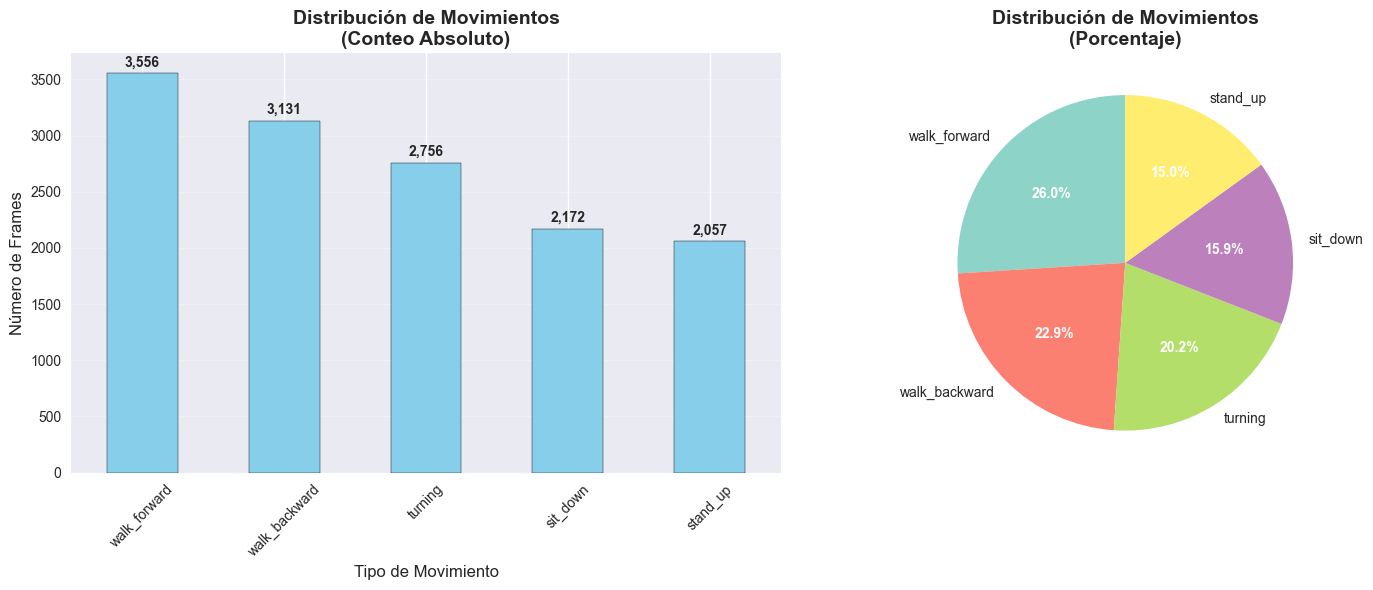

In [53]:
# Conteo de cada movimiento
movement_counts = df['movement'].value_counts()
movement_percentages = df['movement'].value_counts(normalize=True) * 100

print("Distribución de movimientos:")
for movement, count in movement_counts.items():
    percentage = movement_percentages[movement]
    print(f"  {movement}: {count:,} frames ({percentage:.2f}%)")

print(f"\nTotal de frames: {len(df):,}")
print(f"Número de clases: {df['movement'].nunique()}")

# Calcular balance del dataset
min_samples = movement_counts.min()
max_samples = movement_counts.max()
balance_ratio = min_samples / max_samples
print(f"\nRatio de balance (min/max): {balance_ratio:.3f}")

if balance_ratio >= 0.8:
    print("✅ Dataset bien balanceado")
elif balance_ratio >= 0.5:
    print("⚠️ Dataset moderadamente balanceado")
else:
    print("❌ Dataset desbalanceado - considerar técnicas de balanceo")

# Visualización de distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras
movement_counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Distribución de Movimientos\n(Conteo Absoluto)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tipo de Movimiento', fontsize=12)
axes[0].set_ylabel('Número de Frames', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(movement_counts.values):
    axes[0].text(i, v + max(movement_counts)*0.01, f'{v:,}', 
                ha='center', va='bottom', fontweight='bold')

# Gráfico de pastel
colors = plt.cm.Set3(np.linspace(0, 1, len(movement_counts)))
wedges, texts, autotexts = axes[1].pie(movement_counts.values, 
                                      labels=movement_counts.index,
                                      autopct='%1.1f%%',
                                      colors=colors,
                                      startangle=90)
axes[1].set_title('Distribución de Movimientos\n(Porcentaje)', fontsize=14, fontweight='bold')

# Mejorar la apariencia del gráfico de pastel
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

## 4. Análisis de Landmarks y Visibilidad

Visibilidad promedio por landmark:
  right_shoulder: 0.9997
  left_ankle: 0.9503
  right_hip: 0.9935
  left_heel: 0.8790
  right_knee: 0.9579
  left_wrist: 0.8621
  left_hip: 0.9935
  nose: 0.9995
  left_knee: 0.9595
  right_ankle: 0.9479
  right_heel: 0.8646
  left_shoulder: 0.9998
  right_wrist: 0.8423

Landmarks con visibilidad promedio < 0.7:
  ✅ Todos los landmarks tienen buena visibilidad


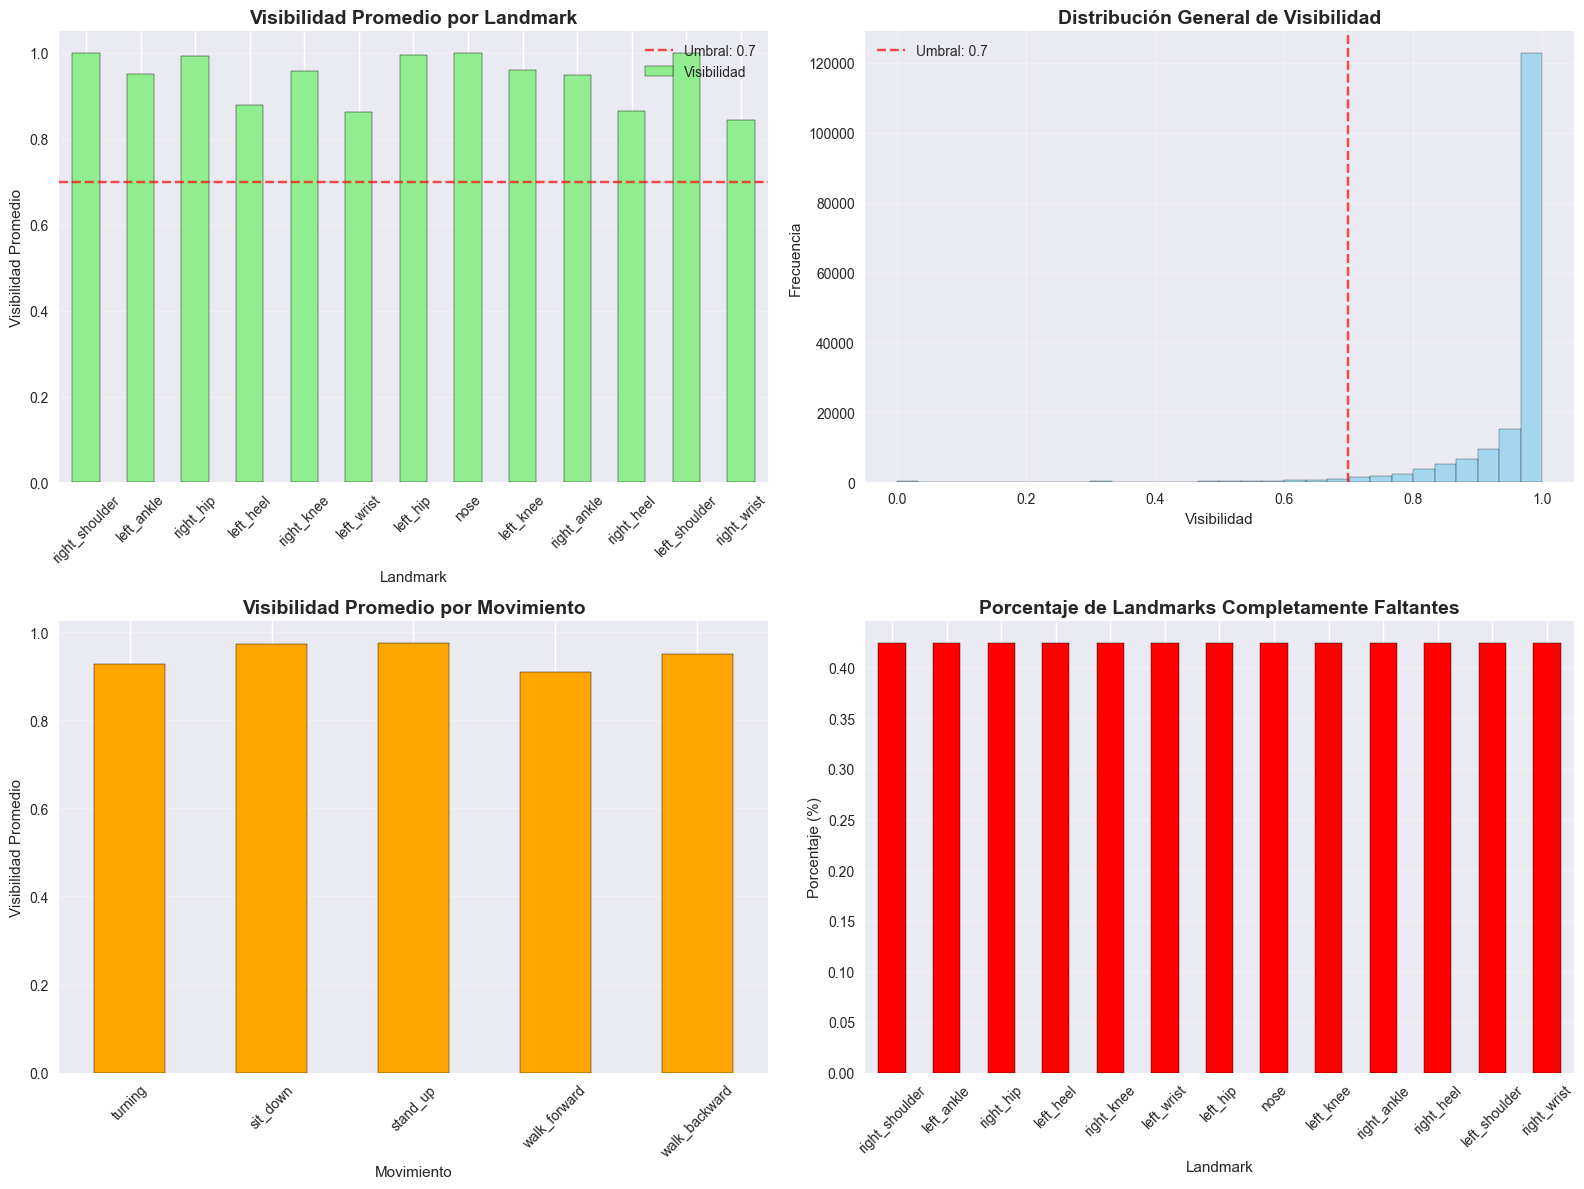

In [54]:
# Análisis de visibilidad por landmark
print("Visibilidad promedio por landmark:")
visibility_stats = {}
for landmark in landmark_names:
    vis_col = f"{landmark}_v"
    if vis_col in df.columns:
        # Excluir valores nulos para el cálculo
        valid_visibility = df[vis_col].dropna()
        if len(valid_visibility) > 0:
            avg_vis = valid_visibility.mean()
            visibility_stats[landmark] = avg_vis
            print(f"  {landmark}: {avg_vis:.4f}")

# Identificar landmarks con baja visibilidad
low_visibility_threshold = 0.7
problematic_landmarks = {k: v for k, v in visibility_stats.items() if v < low_visibility_threshold}

print(f"\nLandmarks con visibilidad promedio < {low_visibility_threshold}:")
if problematic_landmarks:
    for landmark, avg_vis in problematic_landmarks.items():
        print(f"  {landmark}: {avg_vis:.4f}")
else:
    print("  ✅ Todos los landmarks tienen buena visibilidad")

# Visualización de calidad de landmarks
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Visibilidad promedio por landmark
if visibility_stats:
    landmark_vis_df = pd.DataFrame(list(visibility_stats.items()), 
                                   columns=['Landmark', 'Visibilidad'])
    landmark_vis_df.set_index('Landmark')['Visibilidad'].plot(kind='bar', 
                                                              ax=axes[0,0], 
                                                              color='lightgreen', 
                                                              edgecolor='black')
    axes[0,0].set_title('Visibilidad Promedio por Landmark', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Visibilidad Promedio')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].axhline(y=low_visibility_threshold, color='red', linestyle='--', 
                      alpha=0.7, label=f'Umbral: {low_visibility_threshold}')
    axes[0,0].legend()
    axes[0,0].grid(axis='y', alpha=0.3)

# 2. Distribución de visibilidad general
all_visibility = []
for vis_col in visibility_columns:
    all_visibility.extend(df[vis_col].dropna().values)

if all_visibility:
    axes[0,1].hist(all_visibility, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,1].axvline(x=low_visibility_threshold, color='red', linestyle='--', 
                      alpha=0.7, label=f'Umbral: {low_visibility_threshold}')
    axes[0,1].set_title('Distribución General de Visibilidad', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Visibilidad')
    axes[0,1].set_ylabel('Frecuencia')
    axes[0,1].legend()
    axes[0,1].grid(alpha=0.3)

# 3. Visibilidad por movimiento (promedio de todos los landmarks)
movement_visibility = {}
for movement in df['movement'].unique():
    movement_data = df[df['movement'] == movement]
    vis_values = []
    for vis_col in visibility_columns:
        vis_values.extend(movement_data[vis_col].dropna().values)
    if vis_values:
        movement_visibility[movement] = np.mean(vis_values)

if movement_visibility:
    movement_vis_df = pd.DataFrame(list(movement_visibility.items()), 
                                   columns=['Movimiento', 'Visibilidad'])
    movement_vis_df.set_index('Movimiento')['Visibilidad'].plot(kind='bar', 
                                                                ax=axes[1,0], 
                                                                color='orange', 
                                                                edgecolor='black')
    axes[1,0].set_title('Visibilidad Promedio por Movimiento', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('Visibilidad Promedio')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(axis='y', alpha=0.3)

# 4. Porcentaje de valores faltantes por landmark
missing_percentages = {}
for landmark in landmark_names:
    landmark_cols = [col for col in df.columns if col.startswith(landmark)]
    if landmark_cols:
        # Contar filas donde TODAS las coordenadas del landmark son nulas
        landmark_data = df[landmark_cols]
        completely_missing = landmark_data.isnull().all(axis=1).sum()
        missing_percentages[landmark] = (completely_missing / len(df)) * 100

if missing_percentages:
    missing_df = pd.DataFrame(list(missing_percentages.items()), 
                             columns=['Landmark', 'Porcentaje_Faltante'])
    missing_df.set_index('Landmark')['Porcentaje_Faltante'].plot(kind='bar', 
                                                                 ax=axes[1,1], 
                                                                 color='red', 
                                                                 edgecolor='black')
    axes[1,1].set_title('Porcentaje de Landmarks Completamente Faltantes', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('Porcentaje (%)')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Análisis de Distribuciones de Coordenadas

Estadísticas por tipo de coordenada:

Coordenada X:
  min: 0.0867
  max: 1.0021
  mean: 0.5466
  std: 0.0566
  range: 0.9154

Coordenada Y:
  min: -0.2709
  max: 4.1170
  mean: 0.6133
  std: 0.2331
  range: 4.3878

Coordenada Z:
  min: -1.3525
  max: 1.6522
  mean: -0.0237
  std: 0.1686
  range: 3.0048


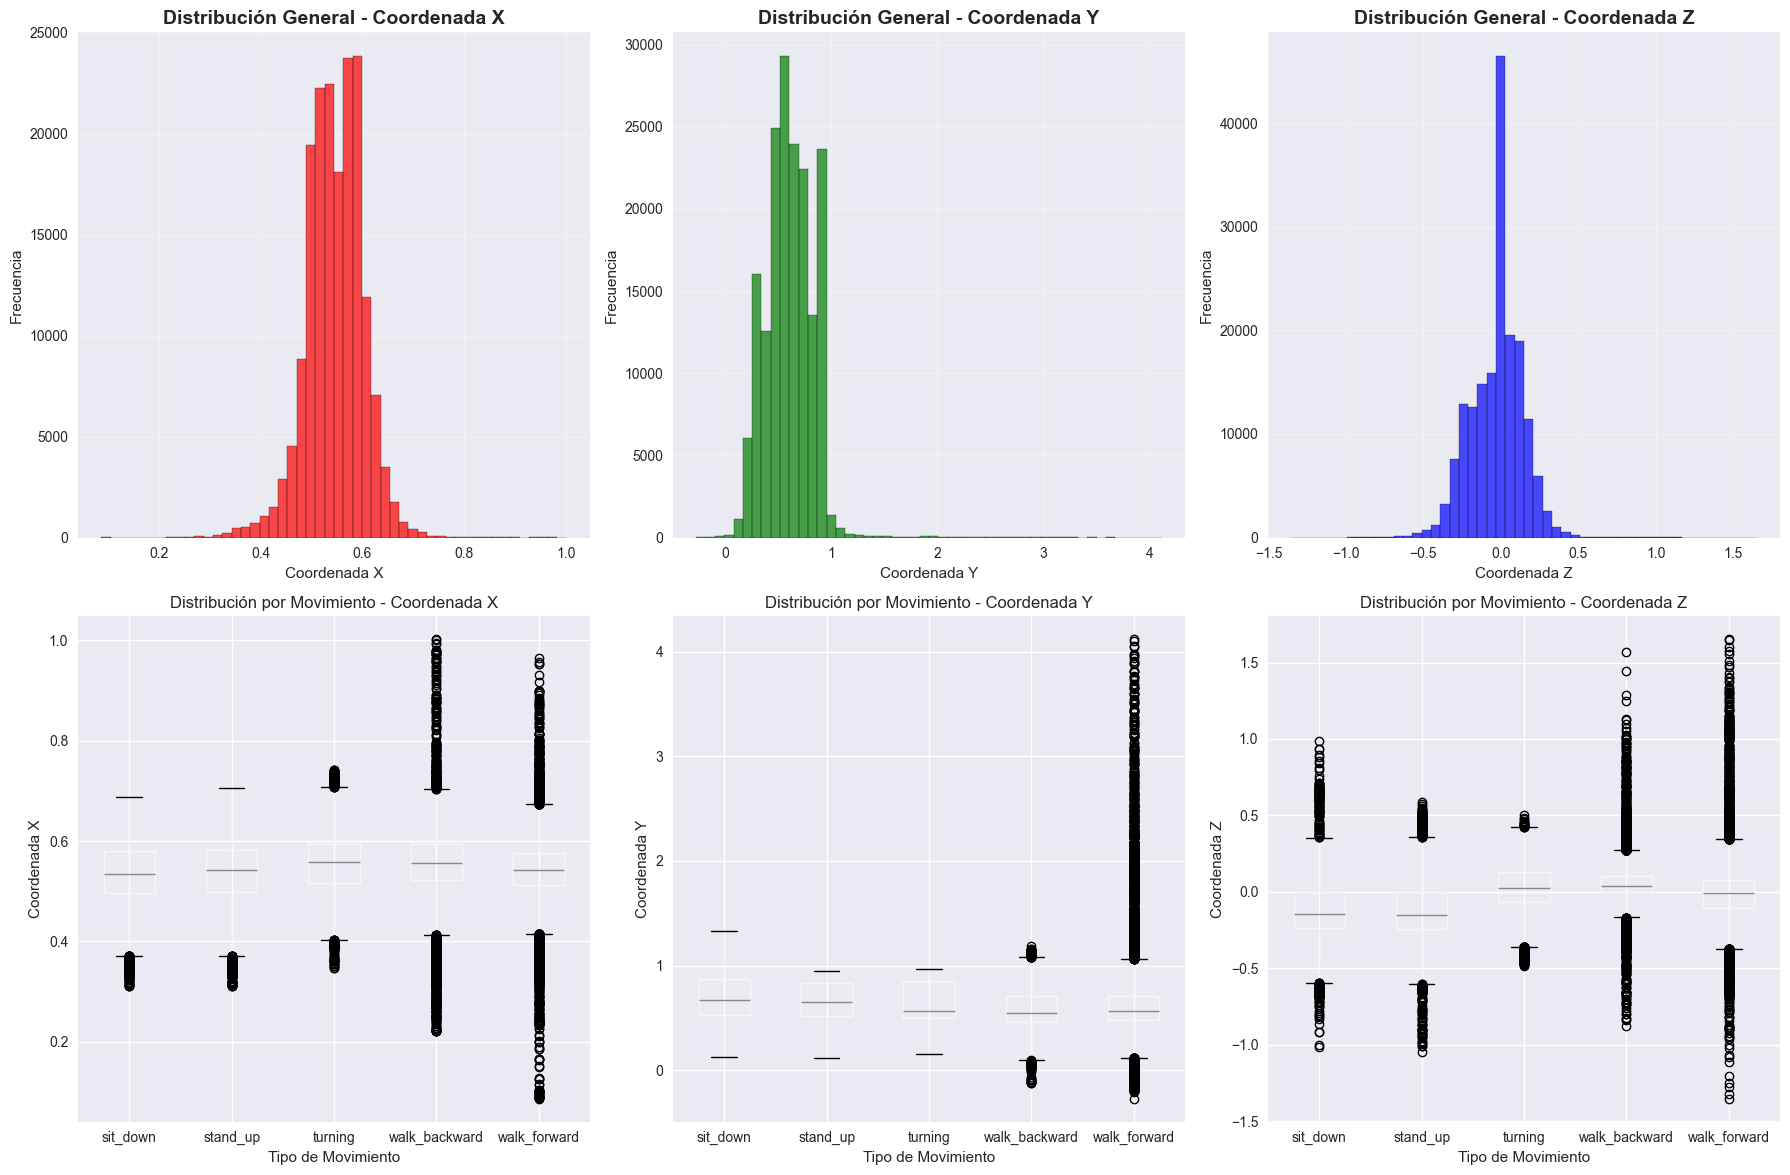

In [55]:
# Analizar rangos de coordenadas por tipo (x, y, z)
coordinate_stats = {}
for coord_type in ['x', 'y', 'z']:
    coord_cols = [col for col in coordinate_columns if col.endswith(f'_{coord_type}')]
    if coord_cols:
        all_coords = []
        for col in coord_cols:
            all_coords.extend(df[col].dropna().values)
        
        if all_coords:
            coordinate_stats[coord_type] = {
                'min': np.min(all_coords),
                'max': np.max(all_coords),
                'mean': np.mean(all_coords),
                'std': np.std(all_coords),
                'range': np.max(all_coords) - np.min(all_coords)
            }

print("Estadísticas por tipo de coordenada:")
for coord_type, stats in coordinate_stats.items():
    print(f"\nCoordenada {coord_type.upper()}:")
    for stat_name, value in stats.items():
        print(f"  {stat_name}: {value:.4f}")

# Visualización de distribuciones por coordenada
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Histogramas de distribuciones generales
for i, coord_type in enumerate(['x', 'y', 'z']):
    coord_cols = [col for col in coordinate_columns if col.endswith(f'_{coord_type}')]
    if coord_cols:
        all_coords = []
        for col in coord_cols:
            all_coords.extend(df[col].dropna().values)
        
        if all_coords:
            axes[0, i].hist(all_coords, bins=50, alpha=0.7, color=['red', 'green', 'blue'][i], 
                           edgecolor='black')
            axes[0, i].set_title(f'Distribución General - Coordenada {coord_type.upper()}', 
                                fontsize=14, fontweight='bold')
            axes[0, i].set_xlabel(f'Coordenada {coord_type.upper()}')
            axes[0, i].set_ylabel('Frecuencia')
            axes[0, i].grid(alpha=0.3)

# Boxplots por movimiento para cada coordenada
for i, coord_type in enumerate(['x', 'y', 'z']):
    coord_cols = [col for col in coordinate_columns if col.endswith(f'_{coord_type}')]
    if coord_cols:
        # Crear un DataFrame temporal para boxplot
        plot_data = []
        for movement in df['movement'].unique():
            movement_data = df[df['movement'] == movement]
            for col in coord_cols:
                coords = movement_data[col].dropna().values
                for coord in coords:
                    plot_data.append({'Movement': movement, 'Coordinate': coord})
        
        if plot_data:
            plot_df = pd.DataFrame(plot_data)
            plot_df.boxplot(column='Coordinate', by='Movement', ax=axes[1, i])
            axes[1, i].set_title(f'Distribución por Movimiento - Coordenada {coord_type.upper()}')
            axes[1, i].set_xlabel('Tipo de Movimiento')
            axes[1, i].set_ylabel(f'Coordenada {coord_type.upper()}')

plt.suptitle('')
plt.tight_layout()
plt.show()

## 6. Análisis Temporal de Secuencias

Análisis de secuencias por movimiento:

turning:
  Total frames: 2756
  Frames únicos: 136
  Número de secuencias: 28
  Longitud promedio: 98.4 frames
  Rango: 56-136 frames

sit_down:
  Total frames: 2172
  Frames únicos: 114
  Número de secuencias: 30
  Longitud promedio: 72.4 frames
  Rango: 45-114 frames

stand_up:
  Total frames: 2057
  Frames únicos: 120
  Número de secuencias: 29
  Longitud promedio: 70.9 frames
  Rango: 48-120 frames

walk_forward:
  Total frames: 3556
  Frames únicos: 150
  Número de secuencias: 28
  Longitud promedio: 127.0 frames
  Rango: 91-150 frames

walk_backward:
  Total frames: 3131
  Frames únicos: 143
  Número de secuencias: 25
  Longitud promedio: 125.2 frames
  Rango: 72-143 frames


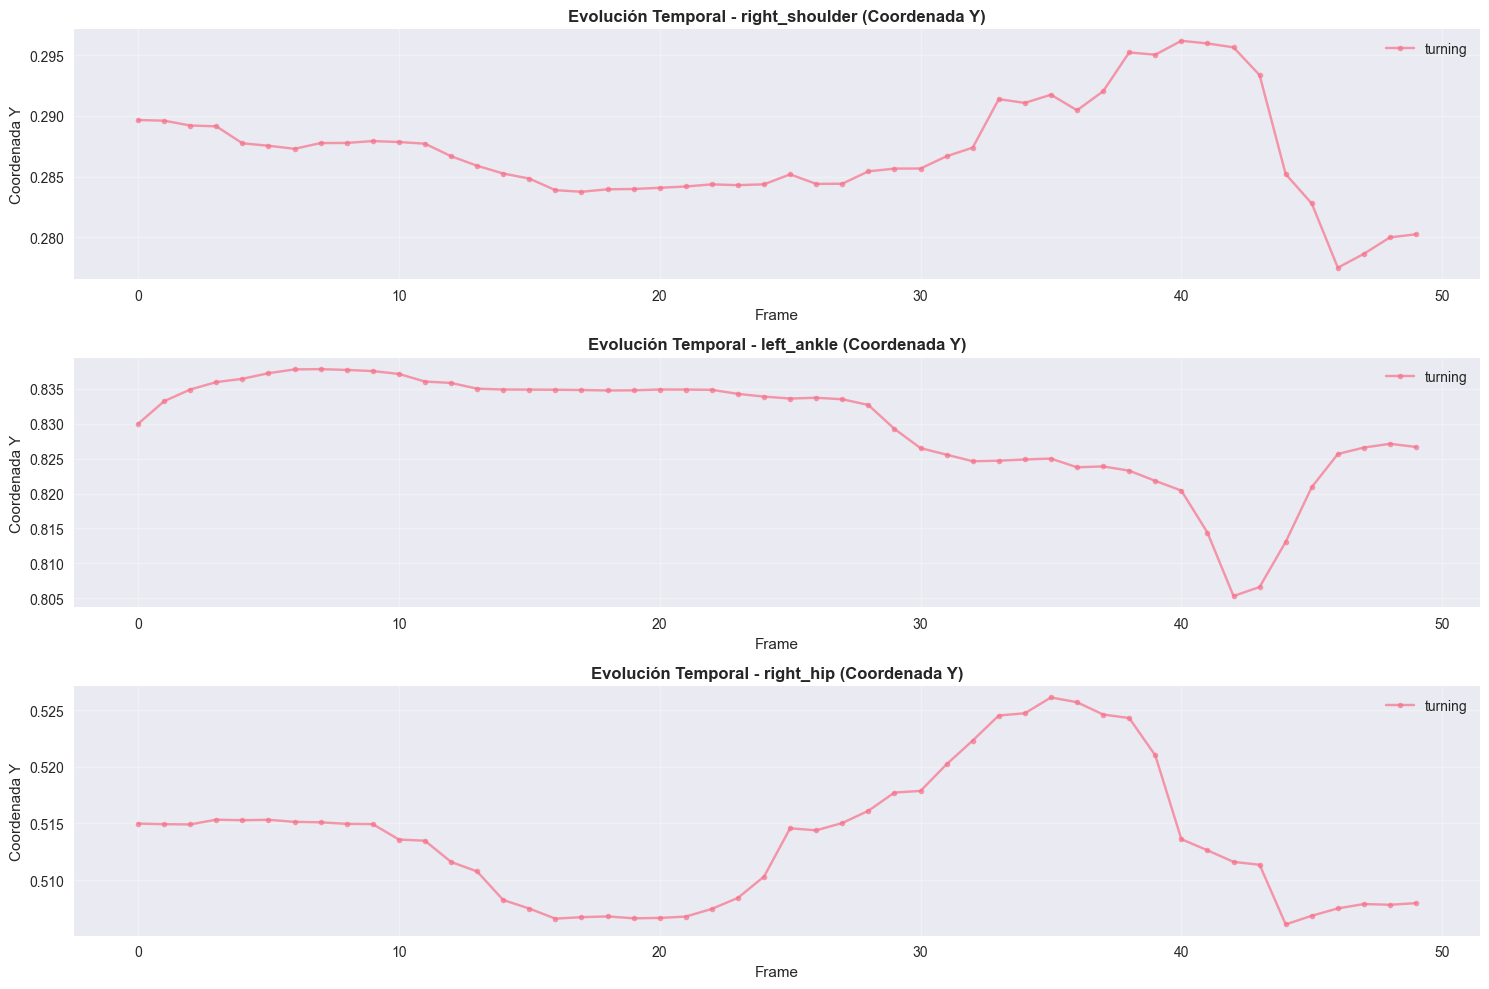

In [56]:
# Análisis de duración de secuencias por movimiento
sequence_analysis = {}
for movement in df['movement'].unique():
    movement_data = df[df['movement'] == movement]
    frames = movement_data['frame'].values
    
    # Identificar secuencias continuas
    sequences = []
    if len(frames) > 0:
        current_seq = [frames[0]]
        for i in range(1, len(frames)):
            if frames[i] == frames[i-1] + 1:
                current_seq.append(frames[i])
            else:
                sequences.append(len(current_seq))
                current_seq = [frames[i]]
        sequences.append(len(current_seq))
    
    sequence_analysis[movement] = {
        'total_frames': len(frames),
        'unique_frames': len(np.unique(frames)),
        'sequences': sequences,
        'avg_sequence_length': np.mean(sequences) if sequences else 0,
        'max_sequence_length': max(sequences) if sequences else 0,
        'min_sequence_length': min(sequences) if sequences else 0
    }

print("Análisis de secuencias por movimiento:")
for movement, analysis in sequence_analysis.items():
    print(f"\n{movement}:")
    print(f"  Total frames: {analysis['total_frames']}")
    print(f"  Frames únicos: {analysis['unique_frames']}")
    print(f"  Número de secuencias: {len(analysis['sequences'])}")
    print(f"  Longitud promedio: {analysis['avg_sequence_length']:.1f} frames")
    print(f"  Rango: {analysis['min_sequence_length']}-{analysis['max_sequence_length']} frames")

# Visualización temporal de landmarks clave
selected_landmarks = landmark_names[:3]  # Tomar los primeros 3 landmarks
sample_frames = 50  # Mostrar primeros 50 frames

fig, axes = plt.subplots(len(selected_landmarks), 1, figsize=(15, 10))
if len(selected_landmarks) == 1:
    axes = [axes]

for i, landmark in enumerate(selected_landmarks):
    y_col = f"{landmark}_y"  # Usar coordenada Y que es más representativa para movimientos
    
    if y_col in df.columns:
        sample_data = df.head(sample_frames)  # Primeros frames
        
        # Plotear por movimiento
        for movement in sample_data['movement'].unique():
            movement_subset = sample_data[sample_data['movement'] == movement]
            if not movement_subset.empty:
                axes[i].plot(movement_subset['frame'], movement_subset[y_col], 
                           'o-', label=movement, alpha=0.7, markersize=4)
        
        axes[i].set_title(f'Evolución Temporal - {landmark} (Coordenada Y)', 
                         fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Frame')
        axes[i].set_ylabel('Coordenada Y')
        axes[i].legend()
        axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Tratamiento de Datos Nulos y Duplicados

In [60]:
# Trabajar con una copia del dataset para el procesamiento
df_processed = df.copy()
print(f"Dataset original: {df_processed.shape}")

# 7.1 TRATAMIENTO DE DUPLICADOS
print(f"\n7.1 🔄 ELIMINACIÓN DE DUPLICADOS")
print("-" * 35)

duplicates_before = df_processed.duplicated().sum()
print(f"Duplicados encontrados: {duplicates_before}")

if duplicates_before > 0:
    df_processed = df_processed.drop_duplicates().reset_index(drop=True)
    duplicates_after = df_processed.duplicated().sum()
    print(f"✅ Duplicados eliminados: {duplicates_before}")
    print(f"Dataset después: {df_processed.shape}")
else:
    print("✅ No se encontraron duplicados")

# 7.2 ANÁLISIS DETALLADO DE VALORES NULOS
print(f"\n7.2 🔍 ANÁLISIS DETALLADO DE VALORES NULOS")
print("-" * 45)

# Estadísticas de completitud por landmark
print("Completitud por landmark (% de frames con coordenadas completas):")
landmark_completeness = {}
for landmark in landmark_names:
    essential_cols = [f"{landmark}_x", f"{landmark}_y", f"{landmark}_z"]
    existing_cols = [col for col in essential_cols if col in df_processed.columns]
    
    if existing_cols:
        # Contar frames donde TODAS las coordenadas esenciales están presentes
        complete_frames = df_processed[existing_cols].dropna().shape[0]
        completeness_pct = (complete_frames / len(df_processed)) * 100
        landmark_completeness[landmark] = completeness_pct
        print(f"  {landmark}: {completeness_pct:.1f}%")

# 7.3 ESTRATEGIAS DE TRATAMIENTO DE NULOS
print(f"\n7.3 🛠️ TRATAMIENTO DE VALORES NULOS")
print("-" * 40)

# Estrategia 1: Eliminar frames con demasiados landmarks faltantes
missing_threshold = 0.7  # Si más del 70% de landmarks faltan, eliminar frame
print(f"Eliminando frames con >{missing_threshold*100}% de landmarks faltantes...")

frames_to_keep = []
for idx, row in df_processed.iterrows():
    coord_values = [row[col] for col in coordinate_columns if pd.notna(row[col])]
    completeness = len(coord_values) / len(coordinate_columns)
    
    if completeness >= (1 - missing_threshold):
        frames_to_keep.append(idx)

frames_removed = len(df_processed) - len(frames_to_keep)
df_processed = df_processed.loc[frames_to_keep].reset_index(drop=True)

print(f"  Frames eliminados: {frames_removed}")
print(f"  Frames restantes: {len(df_processed)}")

# Estrategia 2: Interpolación temporal para valores faltantes esporádicos
print(f"\nAplicando interpolación temporal para valores faltantes...")

interpolation_applied = 0
for movement in df_processed['movement'].unique():
    movement_mask = df_processed['movement'] == movement
    movement_data = df_processed[movement_mask].copy()
    movement_data = movement_data.sort_values('frame')
    
    # Interpolar coordenadas (no visibilidad)
    for col in coordinate_columns:
        if col in movement_data.columns:
            before_nulls = movement_data[col].isnull().sum()
            # Interpolación lineal limitada (máximo 3 frames consecutivos)
            movement_data[col] = movement_data[col].interpolate(method='linear', limit=3)
            after_nulls = movement_data[col].isnull().sum()
            interpolation_applied += (before_nulls - after_nulls)
    
    # Actualizar en el dataset principal
    df_processed.loc[movement_mask, :] = movement_data

print(f"  Valores interpolados: {interpolation_applied}")

# Estrategia 3: Rellenar visibilidad faltante con valores conservadores
print(f"\nTratando valores de visibilidad faltantes...")

visibility_filled = 0
for vis_col in visibility_columns:
    if vis_col in df_processed.columns:
        # Rellenar visibilidad faltante con 0.5 (valor conservador)
        null_count = df_processed[vis_col].isnull().sum()
        df_processed[vis_col] = df_processed[vis_col].fillna(0.5)
        visibility_filled += null_count

print(f"  Valores de visibilidad rellenados: {visibility_filled}")

Dataset original: (13672, 54)

7.1 🔄 ELIMINACIÓN DE DUPLICADOS
-----------------------------------
Duplicados encontrados: 26
✅ Duplicados eliminados: 26
Dataset después: (13646, 54)

7.2 🔍 ANÁLISIS DETALLADO DE VALORES NULOS
---------------------------------------------
Completitud por landmark (% de frames con coordenadas completas):
  right_shoulder: 99.8%
  left_ankle: 99.8%
  right_hip: 99.8%
  left_heel: 99.8%
  right_knee: 99.8%
  left_wrist: 99.8%
  left_hip: 99.8%
  nose: 99.8%
  left_knee: 99.8%
  right_ankle: 99.8%
  right_heel: 99.8%
  left_shoulder: 99.8%
  right_wrist: 99.8%

7.3 🛠️ TRATAMIENTO DE VALORES NULOS
----------------------------------------
Eliminando frames con >70.0% de landmarks faltantes...
  Frames eliminados: 32
  Frames restantes: 13614

Aplicando interpolación temporal para valores faltantes...
  Valores interpolados: 0

Tratando valores de visibilidad faltantes...
  Valores de visibilidad rellenados: 0


## 8. Tratamiento de Outliers

In [61]:
def detect_and_treat_outliers(data, columns, method='iqr', factor=2.0, treatment='cap'):
    """
    Detecta y trata outliers usando método IQR
    treatment: 'cap' (winsorize), 'remove' (eliminar), 'median' (reemplazar con mediana)
    """
    outliers_info = {}
    data_treated = data.copy()
    
    for col in columns:
        if col in data.columns:
            col_data = data[col].dropna()
            if len(col_data) > 0:
                Q1 = col_data.quantile(0.25)
                Q3 = col_data.quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - factor * IQR
                upper_bound = Q3 + factor * IQR
                
                # Identificar outliers
                outlier_mask = (data[col] < lower_bound) | (data[col] > upper_bound)
                outliers_count = outlier_mask.sum()
                
                if outliers_count > 0:
                    if treatment == 'cap':
                        # Winsorización: Limitar a los percentiles
                        data_treated.loc[data_treated[col] < lower_bound, col] = lower_bound
                        data_treated.loc[data_treated[col] > upper_bound, col] = upper_bound
                    elif treatment == 'median':
                        # Reemplazar con mediana
                        median_val = col_data.median()
                        data_treated.loc[outlier_mask, col] = median_val
                
                outliers_info[col] = {
                    'count': outliers_count,
                    'percentage': (outliers_count / len(data)) * 100,
                    'bounds': (lower_bound, upper_bound)
                }
    
    return data_treated, outliers_info

# Aplicar tratamiento de outliers solo a coordenadas (no a visibilidad)
df_processed, outlier_info = detect_and_treat_outliers(
    df_processed, 
    coordinate_columns, 
    factor=2.5,  # Factor más conservador
    treatment='cap'  # Limitar outliers en lugar de eliminar
)

print("Outliers tratados por columna:")
total_outliers_treated = 0
for col, info in list(outlier_info.items())[:10]:  # Mostrar primeros 10
    print(f"  {col}: {info['count']} outliers ({info['percentage']:.2f}%) - Limitados")
    total_outliers_treated += info['count']

print(f"\nTotal de outliers tratados: {total_outliers_treated}")

Outliers tratados por columna:
  nose_x: 170 outliers (1.25%) - Limitados
  nose_y: 21 outliers (0.15%) - Limitados
  nose_z: 7 outliers (0.05%) - Limitados
  left_shoulder_x: 135 outliers (0.99%) - Limitados
  left_shoulder_y: 62 outliers (0.46%) - Limitados
  left_shoulder_z: 137 outliers (1.01%) - Limitados
  right_shoulder_x: 51 outliers (0.37%) - Limitados
  right_shoulder_y: 40 outliers (0.29%) - Limitados
  right_shoulder_z: 131 outliers (0.96%) - Limitados
  left_wrist_x: 139 outliers (1.02%) - Limitados

Total de outliers tratados: 893


## 9. Análisis de Separabilidad de Clases (PCA)


Datos para PCA: (13614, 39)
Features utilizadas: 39 coordenadas

Varianza explicada por cada componente:
  PC1: 0.3426 (34.26%)
  PC2: 0.1802 (18.02%)
  PC3: 0.1668 (16.68%)
Varianza acumulada: 0.6896 (68.96%)
⚠️ Moderado: PCA captura 60-80% de la varianza


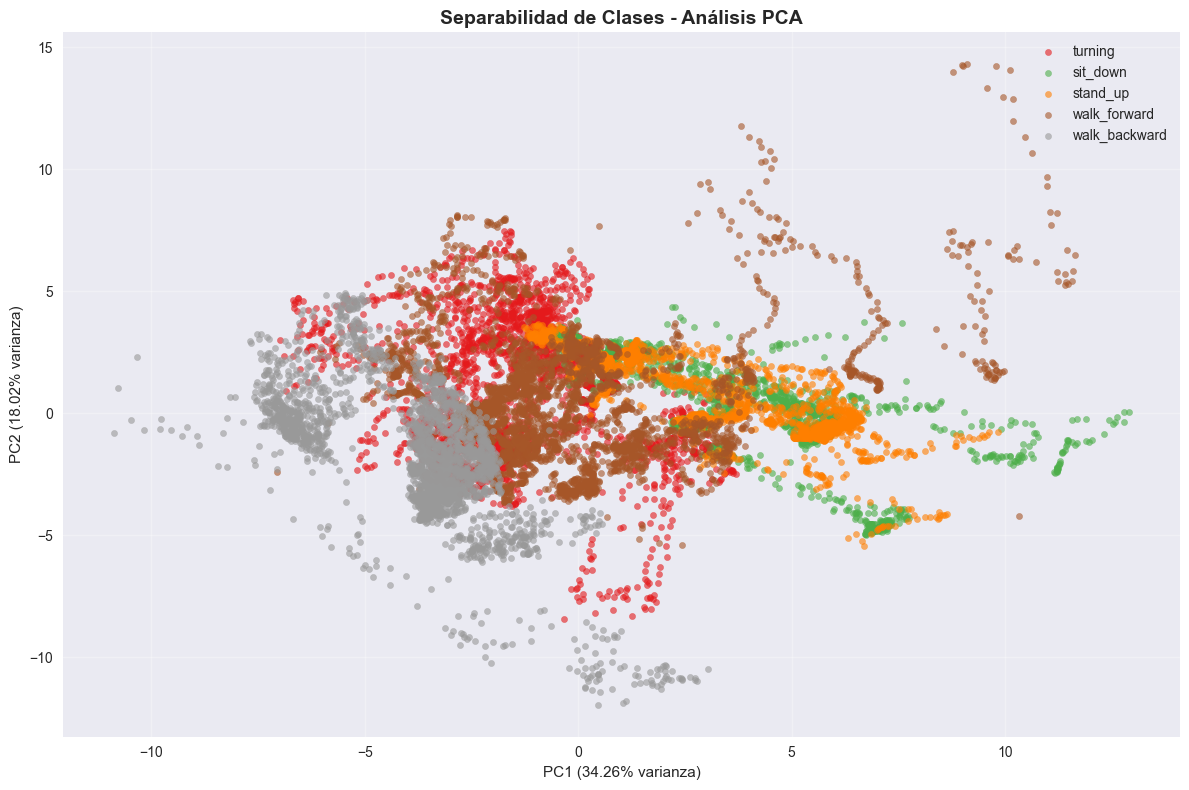


📊 EVALUACIÓN DE SEPARABILIDAD:
   • Si los clusters están bien separados → Clasificador lineal funcionará bien
   • Si hay solapamiento → Necesitaremos algoritmos más complejos
   • Si no hay estructura clara → Datos muy difíciles de clasificar


In [64]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Preparar datos para PCA - usar solo coordenadas (excluir visibilidad por ahora)
feature_columns = coordinate_columns
X = df_processed[feature_columns].dropna()  # Eliminar filas con NaN
y = df_processed.loc[X.index, 'movement']

print(f"\nDatos para PCA: {X.shape}")
print(f"Features utilizadas: {len(feature_columns)} coordenadas")

if len(X) > 0:
    # Escalar las características
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Aplicar PCA
    pca = PCA(n_components=min(3, X.shape[1]))
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"\nVarianza explicada por cada componente:")
    for i, var_ratio in enumerate(pca.explained_variance_ratio_):
        print(f"  PC{i+1}: {var_ratio:.4f} ({var_ratio*100:.2f}%)")
    
    print(f"Varianza acumulada: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")
    
    # Interpretación de resultados
    total_variance = pca.explained_variance_ratio_.sum()
    if total_variance >= 0.8:
        print("✅ Excelente: PCA captura >80% de la varianza")
    elif total_variance >= 0.6:
        print("⚠️ Moderado: PCA captura 60-80% de la varianza")
    else:
        print("❌ Bajo: PCA captura <60% de la varianza - datos muy complejos")
    
    # Crear DataFrame para visualización
    pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    pca_df['movement'] = y.reset_index(drop=True)
    
    # Visualización 2D
    if X_pca.shape[1] >= 2:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        
        colors = plt.cm.Set1(np.linspace(0, 1, len(pca_df['movement'].unique())))
        for i, movement in enumerate(pca_df['movement'].unique()):
            mask = pca_df['movement'] == movement
            ax.scatter(pca_df[mask]['PC1'], pca_df[mask]['PC2'], 
                      c=[colors[i]], label=movement, alpha=0.6, s=20)
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
        ax.set_title('Separabilidad de Clases - Análisis PCA', 
                     fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
                
        # Evaluar separabilidad visual
        print(f"\n📊 EVALUACIÓN DE SEPARABILIDAD:")
        print(f"   • Si los clusters están bien separados → Clasificador lineal funcionará bien")
        print(f"   • Si hay solapamiento → Necesitaremos algoritmos más complejos")
        print(f"   • Si no hay estructura clara → Datos muy difíciles de clasificar")

## 10. Validación Final de Calidad

In [65]:
print(f"Dataset final: {df_processed.shape}")
reduction_percentage = ((len(df) - len(df_processed)) / len(df)) * 100
print(f"Reducción total: {reduction_percentage:.1f}%")

# Verificar nulos restantes
remaining_nulls = df_processed.isnull().sum().sum()
null_percentage_final = (remaining_nulls / (len(df_processed) * len(df_processed.columns))) * 100
print(f"Nulos restantes: {remaining_nulls} ({null_percentage_final:.2f}%)")

# Verificar que todas las clases siguen presentes
movements_final = df_processed['movement'].unique()
if len(movements_final) == len(df['movement'].unique()):
    print(f"✅ Todas las clases preservadas: {len(movements_final)}")
else:
    print(f"⚠️ Clases perdidas en el procesamiento")

# Balance final
final_balance = df_processed['movement'].value_counts()
final_balance_ratio = final_balance.min() / final_balance.max()
print(f"Balance final: {final_balance_ratio:.3f}")

# Comparación antes/después
print(f"\n📊 COMPARACIÓN ANTES/DESPUÉS:")
print(f"   • Frames: {len(df):,} → {len(df_processed):,} (-{reduction_percentage:.1f}%)")
print(f"   • Nulos: {((df.isnull().sum().sum()) / (len(df) * len(df.columns))) * 100:.2f}% → {null_percentage_final:.2f}%")
print(f"   • Balance: {(df['movement'].value_counts().min() / df['movement'].value_counts().max()):.3f} → {final_balance_ratio:.3f}")

Dataset final: (13614, 54)
Reducción total: 0.4%
Nulos restantes: 0 (0.00%)
✅ Todas las clases preservadas: 5
Balance final: 0.581

📊 COMPARACIÓN ANTES/DESPUÉS:
   • Frames: 13,672 → 13,614 (-0.4%)
   • Nulos: 0.41% → 0.00%
   • Balance: 0.578 → 0.581


## 11. Exportación

In [68]:
import os
from pathlib import Path
import json

# Crear directorio para datos procesados
export_dir = Path('data')
export_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 PREPARACIÓN PARA EXPORTACIÓN")
print("-" * 40)

# Optimizar tipos de datos para eficiencia
print(f"Optimizando tipos de datos...")
df_optimized = df_processed.copy()

# Optimizar frame a entero
if df_optimized['frame'].dtype != 'int32':
    df_optimized['frame'] = df_optimized['frame'].astype('int32')

# Optimizar coordenadas a float32 (suficiente precisión para MediaPipe)
for col in coordinate_columns:
    if col in df_optimized.columns and df_optimized[col].dtype == 'float64':
        df_optimized[col] = df_optimized[col].astype('float32')

# Optimizar visibilidad a float32
for col in visibility_columns:
    if col in df_optimized.columns and df_optimized[col].dtype == 'float64':
        df_optimized[col] = df_optimized[col].astype('float32')

# Movement como categoría
df_optimized['movement'] = df_optimized['movement'].astype('category')

memory_before = df_processed.memory_usage(deep=True).sum() / 1024**2
memory_after = df_optimized.memory_usage(deep=True).sum() / 1024**2
memory_reduction = ((memory_before - memory_after) / memory_before) * 100

print(f"  Memoria antes: {memory_before:.2f} MB")
print(f"  Memoria después: {memory_after:.2f} MB")
print(f"  Reducción: {memory_reduction:.1f}%")

# 11.2 EXPORTACIÓN DE ARCHIVOS
print(f"\n💾 EXPORTACIÓN DE ARCHIVOS")
print("-" * 35)

# Dataset completo procesado
full_dataset_path = export_dir / 'motion_dataset_processed.csv'
df_optimized.to_csv(full_dataset_path, index=False)
print(f"✅ Dataset completo: {full_dataset_path}")

# 11.3 METADATOS Y DOCUMENTACIÓN
print(f"\n📋 METADATOS Y DOCUMENTACIÓN")
print("-" * 40)

# Crear metadatos completos
metadata = {
    'dataset_info': {
        'name': 'Human Motion Classification Dataset - Processed',
        'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'original_frames': len(df),
        'processed_frames': len(df_optimized),
        'reduction_percentage': f"{reduction_percentage:.2f}%",
        'memory_optimization': f"{memory_reduction:.1f}%"
    },
    'structure': {
        'total_columns': len(df_optimized.columns),
        'landmark_names': landmark_names,
        'coordinate_columns': len(coordinate_columns),
        'visibility_columns': len(visibility_columns),
        'movements': df_optimized['movement'].cat.categories.tolist(),
        'frame_range': [int(df_optimized['frame'].min()), int(df_optimized['frame'].max())]
    },
    'processing_steps': {
        'duplicates_removed': duplicates_before,
        'frames_removed_low_quality': frames_removed,
        'values_interpolated': interpolation_applied,
        'visibility_filled': visibility_filled,
        'outliers_treated': total_outliers_treated,
        'data_types_optimized': True
    },
    'quality_metrics': {
        'null_percentage_final': float(null_percentage_final),
        'balance_ratio': float(final_balance_ratio),
        'movements_distribution': final_balance.to_dict(),
        'average_visibility': float(df_optimized[visibility_columns].mean().mean()) if visibility_columns else None
    },
    'pca_analysis': {
        'variance_explained_3_components': float(pca.explained_variance_ratio_.sum()) if 'pca' in locals() else None,
        'separability_assessment': 'Good' if 'pca' in locals() and pca.explained_variance_ratio_.sum() > 0.7 else 'Moderate'
    },
    'recommendations': {
        'normalization': 'Apply StandardScaler or MinMaxScaler to coordinate features',
        'feature_engineering': [
            'Calculate distances between key landmarks',
            'Compute velocities between consecutive frames',
            'Create angle features between joints'
        ],
        'algorithms': [
            'Random Forest (robust to remaining NaNs)',
            'XGBoost/LightGBM (excellent for tabular data)',
            'LSTM/GRU (for temporal patterns)',
            'SVM with RBF kernel'
        ],
        'validation': 'Use stratified cross-validation, consider temporal splits for sequences'
    }
}

# Guardar metadatos
metadata_path = export_dir / 'dataset_metadata.json'
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False, default=str)

print(f"✅ Metadatos: {metadata_path}")

# 11.3 VERIFICACIÓN FINAL DE ARCHIVOS
print(f"\n🔍 VERIFICACIÓN FINAL DE ARCHIVOS")
print("-" * 45)

exported_files = [full_dataset_path, metadata_path]

total_size = 0
for file_path in exported_files:
    if file_path.exists():
        size_mb = file_path.stat().st_size / 1024**2
        total_size += size_mb
        print(f"  ✅ {file_path.name}: {size_mb:.2f} MB")
    else:
        print(f"  ❌ {file_path.name}: No encontrado")

print(f"\nTamaño total exportado: {total_size:.2f} MB")

📁 PREPARACIÓN PARA EXPORTACIÓN
----------------------------------------
Optimizando tipos de datos...
  Memoria antes: 6.27 MB
  Memoria después: 2.77 MB
  Reducción: 55.9%

💾 EXPORTACIÓN DE ARCHIVOS
-----------------------------------
✅ Dataset completo: data\motion_dataset_processed.csv

📋 METADATOS Y DOCUMENTACIÓN
----------------------------------------
✅ Metadatos: data\dataset_metadata.json

🔍 VERIFICACIÓN FINAL DE ARCHIVOS
---------------------------------------------
  ✅ motion_dataset_processed.csv: 7.47 MB
  ✅ dataset_metadata.json: 0.00 MB

Tamaño total exportado: 7.47 MB
